In [ ]:
pip install d2l==0.17.6

In [ ]:
# 互相关运算
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X, K):
  '''二维互相关运算'''
  h, w = K.shape # 卷积核的行数和列数
  Y = torch.zeros(size=(X.shape[0] - h + 1, X.shape[1] - w + 1)) # 输出的行数和列数
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      Y[i, j] = (X[i:i+h, j:j+w] * K).sum()
  return Y
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [ ]:
# 卷积层
class Conv2D(nn.Module):
  def __init__(self, kernel_size):
    super().__init__()
    self.weight = nn.Parameter(torch.rand(kernel_size))
    self.bias = nn.Parameter(torch.zeros(1))

  def forward(self, X):
    return corr2d(X, self.weight) + self.bias

In [ ]:
# 图像中目标的边缘检测
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [ ]:
K = torch.tensor([[1.0, -1.0]])
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [ ]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [ ]:
# 学习卷积核
# 构造一个二维卷积层，它具有一个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2d(1, 1, kernel_size=(1,2), bias=False)

# 这个二维卷积层使用四维输入和输出格式（批量大小，通道，高度，宽度）
# 其中批量大小和通道都为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2

for i in range(10):
  Y_hat = conv2d(X)
  l = (Y_hat - Y) ** 2
  conv2d.zero_grad()
  l.sum().backward()
  # 迭代卷积核
  conv2d.weight.data[:] -= lr * conv2d.weight.grad
  if (i+1) % 2 == 0:
    print(f'epoch {i+1}, loss {l.sum():.3f}')

epoch 2, loss 7.162
epoch 4, loss 2.341
epoch 6, loss 0.860
epoch 8, loss 0.335
epoch 10, loss 0.135


In [ ]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 1.0295, -0.9542]])

# 6.3 填充和步幅

In [ ]:
# 填充
import torch
from torch import nn

# 为方便起见，我们定义一个计算卷积的函数
# 此函数初始化卷积层权重，并对输入和输出扩大和缩减相应的维数
def comp_conv2d(conv2d, X):
  # 这里的（1，1）表示批量大小和通道数都是1
  X = X.reshape((1, 1) + X.shape)
  Y = conv2d(X)
  # 省略前两个维度：批量大小和通道
  return Y.reshape(Y.shape[2:])

# 这里每侧边都填充了一行或一列，因此总共添加了2行或2列
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [ ]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [ ]:
# 步幅
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [ ]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

# 6.4 多输入多输出通道

In [ ]:
# 多输入通道
import torch
from d2l import torch as d2l
def corr2d_multi_in(X, K):
  # 先遍历X和K的第0个维度（通道维度），再把它们加在一起
  return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]], [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]],[[1.0, 2.0], [3.0, 4.0]]])
corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [ ]:
# 多输出通道
def corr2d_multi_in_out(X, K):
  # 迭代k的第0个维度，每次都对输入X执行互相关运算
  # 最后将所有结果都叠加到一起
  return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

K = torch.stack((K, K+1, K+2), 0)
K.shape # K为3个输出通道，2个输入通道

torch.Size([3, 2, 2, 2])

In [ ]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

In [ ]:
# 1*1卷积层
def corr2d_multi_in_out_1x1(X, K):
  c_i, h, w = X.shape
  c_o = K.shape[0]
  X = X.reshape((c_i, h*w))
  K = K.reshape((c_o, c_i))
  # 全连接层中的矩阵乘法
  Y = torch.matmul(K, X)
  return Y.reshape((c_o, h, w))

X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

# 6.5 汇聚层（池化层）

In [16]:
# 实现汇聚层的前向传播
import torch
from torch import nn
from d2l import torch as d2l

def pool2d(X, pool_size, mode='max'):
  p_h, p_w = pool_size
  Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      if mode == 'max':
        Y[i, j] = X[i:i + p_h, j:j + p_w].max()
      elif mode == 'avg':
        Y[i, j] = X[i:i + p_h, j:j + p_w].mean()
  return Y

In [17]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, pool_size=(2, 2), mode='max')

tensor([[4., 5.],
        [7., 8.]])

In [18]:
pool2d(X, pool_size=(2, 2), mode='avg')

tensor([[2., 3.],
        [5., 6.]])

In [19]:
# 加入填充和步幅
X = torch.arange(16, dtype = torch.float32).reshape(1, 1, 4, 4) # 输入X有四个维度，其中批量大小和通道数都为1，X为4x4
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [20]:
pool2d = nn.MaxPool2d(3) # 默认情况下，步幅与汇聚窗口大小相同
pool2d(X)

tensor([[[[10.]]]])

In [21]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [22]:
pool2d = nn.MaxPool2d((2, 3), padding=(0, 1), stride=(2, 3))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [ ]:
# 多个通道
X = torch.cat((X, X+1), 1)
X

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

# 6.6 卷积神经网络（LeNet）

In [ ]:
pip uninstall matplotlib

In [ ]:
pip install --upgrade pip

In [ ]:
pip install matplotlib

In [7]:
# 模型代码
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [8]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__,'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [9]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

100%|██████████| 26421880/26421880 [00:02<00:00, 11562503.92it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 170885.44it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:08<00:00, 532128.21it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5476103.73it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的精度。"""
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [11]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.453, train acc 0.830, test acc 0.813
37132.8 examples/sec on cuda:0


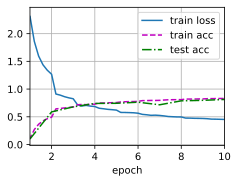

In [12]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())